In [37]:
#Import libraries
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats, integrate
import seaborn as sns

In [38]:
aisles = pd.DataFrame.from_csv('aisles.csv', index_col=None)
aisles.head(10)

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation
5,6,other
6,7,packaged meat
7,8,bakery desserts
8,9,pasta sauce
9,10,kitchen supplies


In [39]:
orders = pd.DataFrame.from_csv('orders.csv', index_col=None)
orders.head(10)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0
5,3367565,1,prior,6,2,7,19.0
6,550135,1,prior,7,1,9,20.0
7,3108588,1,prior,8,1,14,14.0
8,2295261,1,prior,9,1,16,0.0
9,2550362,1,prior,10,4,8,30.0


In [40]:
products = pd.DataFrame.from_csv('products.csv', index_col=None)
products.head(10)

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13
5,6,Dry Nose Oil,11,11
6,7,Pure Coconut Water With Orange,98,7
7,8,Cut Russet Potatoes Steam N' Mash,116,1
8,9,Light Strawberry Blueberry Yogurt,120,16
9,10,Sparkling Orange Juice & Prickly Pear Beverage,115,7


In [41]:
prior_orders = pd.DataFrame.from_csv('order_products__prior.csv', index_col=None)
prior_orders.head(10)

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0
5,2,17794,6,1
6,2,40141,7,1
7,2,1819,8,1
8,2,43668,9,0
9,3,33754,1,1


In [42]:
departments = pd.DataFrame.from_csv('departments.csv', index_col=None)
departments.head(10)

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol
5,6,international
6,7,beverages
7,8,pets
8,9,dry goods pasta
9,10,bulk


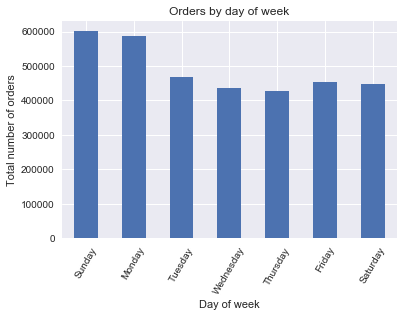

In [43]:
#Order day of week
orders_arr = orders
orders_dow = orders_arr.order_dow.value_counts()
orders_plot = orders_dow.sort_index().plot(kind='bar',title='Orders by day of week')
orders_plot.set_xlabel("Day of week")


orders_plot.set_ylabel("Total number of orders");

dow_map= {0:'Sunday', 1:'Monday', 2:'Tuesday', 3:'Wednesday',
              4:'Thursday', 5:'Friday', 6:'Saturday'}

orders_plot.set_xticklabels([dow_map[d] for d in orders_dow.sort_index().index],rotation=60);

In [44]:
print("Total Number of Users: ",len(orders.user_id.unique()))

Total Number of Users:  206209


Approach: For each user, get 30 most popular products. In the matrix, calculate the Jaccard ratio (A intersection B / AUB). Get the 5 highest ratio for the user. Get the products another user hasn't gotten.

In [45]:
#Join prior_orders table with orders table
orders_combined=prior_orders.merge(orders)

In [46]:
orders_combined.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,202279,prior,3,5,9,8.0
1,2,28985,2,1,202279,prior,3,5,9,8.0
2,2,9327,3,0,202279,prior,3,5,9,8.0
3,2,45918,4,1,202279,prior,3,5,9,8.0
4,2,30035,5,0,202279,prior,3,5,9,8.0


In [47]:
#Get 'N' users with the most number of orders
def getNUsers(n):
    copy_orders = orders_combined
    groupedByUser = copy_orders.groupby('user_id').agg({'product_id':'size'})
    topUsers= groupedByUser.sort_values('product_id',ascending=False).head(n).reset_index()
    topUsers = pd.DataFrame(topUsers['user_id'])
    return topUsers

topUsers = getNUsers(n=200)

In [48]:
#Get users and products columns
users_products = orders_combined[['product_id','user_id']]

In [49]:
#Testing
temp = users_products.head()
temp.loc[temp['product_id'].isin([33120])]

,product_id,user_id
0,33120,202279


In [50]:
usersProducts_copy = users_products

In [51]:
temp = usersProducts_copy.loc[usersProducts_copy['user_id'].isin([201268])]

In [52]:
#For the N users from above, get all of their purchases
def getProductsForUser(userId):
    productsOrdered = usersProducts_copy.loc[usersProducts_copy['user_id'].isin([userId])]
    productsOrdered = productsOrdered[['product_id']].sort_values('product_id',ascending=False).product_id.unique()
    return productsOrdered

In [53]:
#Prepare a dictionary of purchases for each individual
userPurchases={} #Dictionary of user purchases
def prepareDictionary (arrUsers):
    for x in arrUsers:
        userPurchases[x[0]] = getProductsForUser(userId=x[0])

prepareDictionary(topUsers.values)

In [54]:
jaccard_matrix = [[0 for x in range(len(topUsers))] for y in range(len(topUsers))] 

In [55]:
#Let's build a recommendation for a user
import heapq
def recommendationUserX(userId):
    toprecommendations =[]
    jaccardArr = np.zeros(len(userPurchases))
    userXPurchases = userPurchases[userId]
    for index in range(len(userId_arr)):
        jaccardArr[index] = len(set(userXPurchases).intersection(userPurchases[userId_arr[index]]))/(len(userXPurchases)+len(userPurchases[userId_arr[index]]))
    mostSimilar = heapq.nlargest(2,jaccardArr)[1]
    mostSimilarUserIndex = jaccardArr.tolist().index(mostSimilar)
    productsForSimilarUser = userPurchases[userId_arr[mostSimilarUserIndex]]
    productsForCurrentUser = userPurchases[userId]
    for item in productsForSimilarUser:
        if item not in productsForCurrentUser:
            toprecommendations.append(item)
    recommendations_df = pd.DataFrame(toprecommendations)
    recommendations_df = recommendations_df.rename(columns={0:'product_id'})
    recommendations_df = recommendations_df.merge(products)[['product_id','product_name']]
    return recommendations_df[0:10]

In [56]:
userId_arr = list(userPurchases.keys())
recommendations = recommendationUserX(userId_arr[0])

In [57]:
currentPurchases = userPurchases[userId_arr[0]]
pd.DataFrame(currentPurchases).rename(columns={0:'product_id'}).merge(products[['product_id','product_name']]).head(10)

,product_id,product_name
0,49451,Artichoke Spinach Dip
1,49330,Lemonaise
2,49300,Salted Toffee 55% Dark Chocolate
3,49260,Organic Purely Peppermint Tea Bags 16 Count
4,49241,Organic Original Hot Oatmeal
5,49235,Organic Half & Half
6,49111,Original Instant Oatmeal
7,48988,Unsweetened Premium Iced Tea
8,48974,Organic Asian Sesame Dressing
9,48946,Earl Grey Tea


In [58]:
recommendations

,product_id,product_name
0,49683,Cucumber Kirby
1,49628,Yoghurt Blueberry
2,49264,Organic Earl Grey Noir Tea Bags 20 Count
3,48747,Oh My Yog! Gingered Pear Trilayer Yogurt
4,48726,Organic Nonfat Greek Yogurt With Peaches
5,48102,Emperor's Pu-Erh Tea
6,47965,TLC Cherry Dark Chocolate Chewy Granola
7,47766,Organic Avocado
8,47087,Total 0% Blueberry Acai Greek Yogurt
9,47029,Organic Greek Nonfat Yogurt With Mixed Berries


<b> Initial Observations</b>
<br>
Although there is no test data set to test which items were recommended and which of those recommended items the user ended up buying, the recommendations derived for the user above seems to be very reasonable. The user seems to like a lot of organic products and as such, the similarity measure ended up selecting a user who also buys a lot of organic goods. Recommendations such as Acai Greek Yogurt, Organic Avocado, Organic Earl Grey Tea , TLC Cherry Dark Chocolate seem very relevant recommendations for the user we are analyzing. The user seems to make healthy eating choices and the recommendations the user got all seem to be healthy items. 
<p>
<b>Potential Improvements</b>
<br>
One thing to note, however, is that getting a ranking of items to recommend might not work out that well. For instance, in the above example, if we simply took the first 3 items to recommend based on popularity, we might miss out on items that the user would be more likely to buy based on past purchasing behavior. Thus, a good approach would be to get top 10-20 products from the most similar user and use more filtering techniques to identify the top 3-4 from the 20. In our case, we could have filtered for organic food because the user seems to purchase several organic products. 
<p>
Another method that could perform better is using K-nearest neighbors. Instead of just selecting one user that is most similar, we could select k-nearest neighbors and get 2-3 items that are common amongst all neighbors but not the user we are analyzing. 
<p><b>Why Jaccard Similarity Works</b>
<br>Jaccard Similarity works pretty well when the data we have is sparse. This is particularly true for a dataset we have used because there are large number of available products but the fraction of products that a particular user purchases is very small. It also works in the case where one user purchases way more than the other because even though the intersection includes many products, the ratio by minimized by having a high denominator. 
